# Q2

In [187]:
from scipy.integrate import solve_bvp
from scipy.integrate import solve_ivp
from scipy.linalg import solve_continuous_are
from scipy.integrate import simpson
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from tabulate import tabulate

### Boundary Value Problem

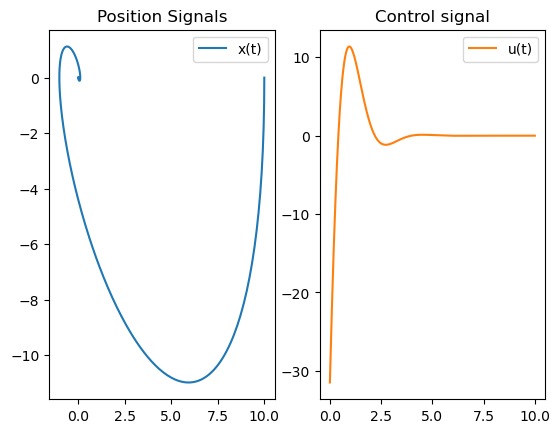

In [188]:
#Create our independent variable nodes. 
t = np.linspace(0,10,1000)
dt = 10/1000

#Create our matrices.
A = np.array([[0, 1],
            [-1.6, -0.4]])

B = np.array([[0], 
              [1]])

Q = np.array([[2, 0],
            [0, 0.01]])

R = np.array([0.1])

P1 = np.array([[1, 0],
            [0, 0.01]])

# The order that we implement this is crucial. In this case, 
# we will solve the xdot function first.

## Create our function

#Reshape because numpy reads the matrix as a (R,) instead of a (R,1) which throws an error.
#None created a Row vector when placed before, and a Column vector when placed after. Replaces the "lost" axis when slicing.
def bvp(x,y):
    return np.vstack((A[None,0] @ np.vstack([y[0],y[1]]) - ((B @ (1/R)).reshape(2,1) @ B.T)[None,0] @ np.vstack([y[2],y[3]]), ##x_dot1 
                      A[None,1] @ np.vstack([y[0],y[1]]) - ((B @ (1/R)).reshape(2,1) @ B.T)[None,1] @ np.vstack([y[2],y[3]]), ##x_dot2
                     -Q[None,0] @ np.vstack([y[0],y[1]]) - A.T[None,0] @ np.vstack([y[2],y[3]]),   ##p_dot1
                     -Q[None,1] @ np.vstack([y[0],y[1]]) - A.T[None,1] @ np.vstack([y[2],y[3]]),   ##p_dot2
                     ))

#Create our boundary conditions
def bc(ya, yb):
    return np.array([ya[0] - 10,
                     ya[1],
                     yb[2] - (P1.T[0] @ np.vstack([yb[0],yb[1]]))[0], #Indexing prevents any deprecation issues in NumPy
                     yb[3] - (P1.T[1] @ np.vstack([yb[0],yb[1]]))[0]
                    ])
#Create our guess 
y = np.zeros((4,t.size))

#Call our function
sol = solve_bvp(bvp, bc, t, y, verbose=0) #Change verbosity to have an idea of the kind of 

#Create our solution arrays
xsol = sol.y[(0,1),:]
psol = sol.y[(2,3),:] 
usol = -(1/R) @ B.T @ psol #row vector.

#Plot the x and u control signals. 
fig, axs = plt.subplots(1,2)
axs[0].plot(xsol[0],xsol[1], label="x(t)")
# axs[0].plot(t,xsol[1], "tab:red", label="x2(t)")
axs[0].set_title("Position Signals")
axs[0].legend()

#Plotting the control signal 
axs[1].plot(t, usol, "tab:orange", label="u(t)")
axs[1].set_title("Control signal")
axs[1].legend()

### Directional Derivatives

In [190]:
## Create the v function with parameter inputs.
def v(t_step, a, b, c, d):
    return np.array([a * math.sin(b * t_step + c) + d])

def z_fun(t,y):
    v = a * math.sin(b * t + c) + d
    return np.array([A @ y + B * v])
    
#Initialize our difference vector
diff_vec = []

for j in range(10):
    ##Seed our random numbers and generate the v parameters. 
    random.seed()
    a = random.uniform(0,10)
    b = random.uniform(0,10)
    c = random.uniform(0,10)
    d = random.uniform(0,10)

    ##Initialize perturbation vectors.
    z = np.zeros((2, t.size))
    vv = np.zeros((t.size))

    ##Simulate the z vector forward using z_dot = A*z + B*v. Simulate it using solve_ivp
    solivp = solve_ivp(z_fun,[0,10],z[:,0],t_eval= t,vectorized = True)
    z = solivp.y

    for i in range(len(t)-1):
        #Assign values to the v_vector
        vv[i] = v(t[i], a, b, c, d)    

    #Now that we have z based on v, we can solve the directional derivative.
    #Initialize an array for the integral at each timestep.
    integral = np.zeros((t.size))
    for ii in range(len(t)):
        #Calculate the integral at each timestep. 
        integral[ii] = (xsol[:,ii,None].T @ Q @ z[:,ii,None])[0] + usol[ii] * R * vv[ii]  

    #Sum the integral and the terminal cost.
    difference = simpson(integral,t) + xsol[:,-1,None].T @ P1 @ z[:,-1,None]
    diff_vec.append([difference[0,0],"{:.2f} sin({:.2f}t + {:.2f}) + {:.2f}".format(a,b,c,d)])
    
#Tabulate the data 
col_names = ["Difference","Direction"]
print(tabulate(diff_vec, headers=col_names))

  Difference  Direction
------------  -----------------------------
 0.00132736   6.24 sin(4.46t + 0.77) + 7.07
-0.00013169   3.81 sin(0.21t + 7.45) + 0.48
-0.000479213  4.58 sin(5.43t + 5.87) + 3.56
-0.00215002   1.57 sin(3.59t + 8.47) + 7.99
 0.00115714   4.64 sin(6.27t + 6.98) + 5.75
-0.000754079  8.93 sin(6.58t + 7.08) + 3.04
 0.000644231  4.45 sin(1.20t + 3.60) + 2.34
 0.00538792   8.08 sin(2.17t + 1.46) + 6.67
 0.00515925   9.59 sin(2.12t + 1.63) + 6.86
 0.00186705   5.24 sin(3.17t + 0.35) + 1.61


# Q3

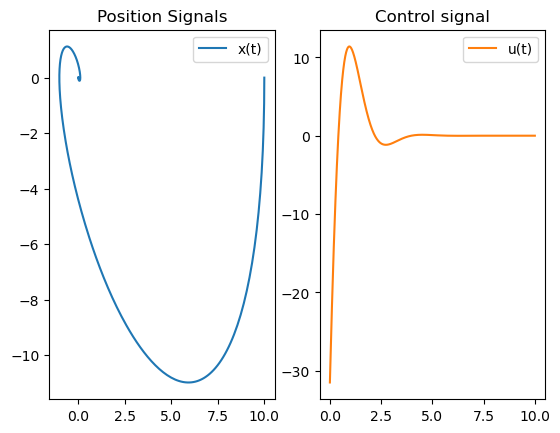

In [191]:
#Solve the Ricotti Equations
P = solve_continuous_are(A,B,Q,R)

def ivp(t,y):
    return A @ y - (B @ (1/R)).reshape(2,1) @ B.T @ P @ y

#Solve for x 
x = solve_ivp(ivp,[0,10],np.array([10,0]),t_eval= t,vectorized = True)
x_new = x.y

#Solve for p 
p = P @ x_new

#solve for u 
u = -(1/R) @ B.T @ p

#Plot the x and u control signals. 
fig, axs = plt.subplots(1,2)
axs[0].plot(x_new[0],x_new[1], label="x(t)")
# axs[0].plot(t,xsol[1], "tab:red", label="x2(t)")
axs[0].set_title("Position Signals")
axs[0].legend()

#Plotting the control signal 
axs[1].plot(t, u, "tab:orange", label="u(t)")
axs[1].set_title("Control signal")
axs[1].legend()

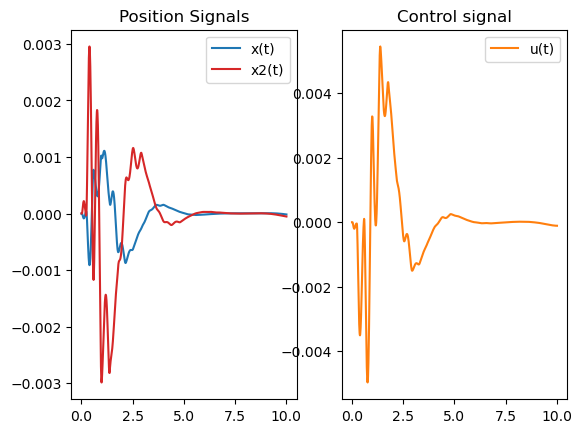

In [192]:
#Plot the x and u control signals. 
fig, axs = plt.subplots(1,2)
axs[0].plot(t, x_new[0]-xsol[0], label="x(t)")
axs[0].plot(t,x_new[1]-xsol[1], "tab:red", label="x2(t)")
axs[0].set_title("Position Signals")
axs[0].legend()

#Plotting the control signal 
axs[1].plot(t, u-usol, "tab:orange", label="u(t)")
axs[1].set_title("Control signal")
axs[1].legend()